In [1]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Misc
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


Trying to figure out methods in building a good transfer model... [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction.
### Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

### Why only reuse the convolutional base? 

Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

In [2]:
print('================ SETTING DIRECTORY ================')

================ SETTING DIRECTORY ================


In [3]:
# Dimensions of our images
WIDTH, HEIGHT = 150, 150

In [4]:
weights_path  = '../00-model-weights/vgg16_weights.h5'
weights_notop_path  = '../00-model-weights/vgg16_weights_notop.h5'
top_model_weights_path  = 'bottleneck_fc_model.h5'

In [5]:
base_dir = 'images/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

nb_train_samples = 2000
nb_test_samples = 1000
nb_validation_samples = 1000
epochs = 5
batch_size = 20

In [6]:
# Set custom input tensor shape
input_tensor = Input(shape=(WIDTH, HEIGHT, 3))

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [7]:
# Build the VGG network
print('================ MODEL LOADING ================')
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
print('================ MODEL LOADED ================')

================ MODEL LOADING ================
Instructions for updating:
Colocations handled automatically by placer.
================ MODEL LOADED ================


In [8]:
base_model.output_shape[1:]

(4, 4, 512)

Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (nb_train_samples, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (nb_validation_samples, 4 * 4 * 512))
test_features = np.reshape(test_features, (nb_test_samples, 4 * 4 * 512))

### Train a dense model

In [12]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 440us/step - loss: 0.5932 - acc: 0.6730 - val_loss: 0.4472 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 0s 232us/step - loss: 0.4239 - acc: 0.8020 - val_loss: 0.3658 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 0s 223us/step - loss: 0.3622 - acc: 0.8465 - val_loss: 0.3314 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 0s 227us/step - loss: 0.3274 - acc: 0.8620 - val_loss: 0.3106 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 0s 216us/step - loss: 0.3030 - acc: 0.8720 - val_loss: 0.2979 - val_acc: 0.8750
Epoch 6/30
2000/2000 [==============================] - 0s 217us/step - loss: 0.2763 - acc: 0.8820 - val_loss

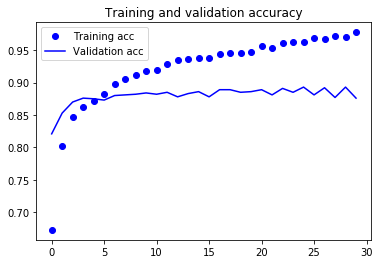

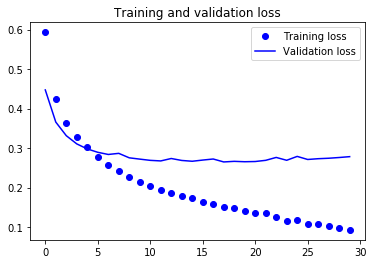

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Result : Overfitting
We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

### Review the second technique 
We mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [14]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [17]:
base_model.trainable = False

In [18]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning.

In [19]:
base_model.layers

In [20]:
model.layers

### Start training the whole thing, with a very slow learning rate

In [21]:
# Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_gen = train_datagen.flow_from_directory(
        'images/split/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
#         shuffle=False
)

validation_gen = validation_datagen.flow_from_directory(
        'images/split/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
#         shuffle=False
)

test_gen = test_datagen.flow_from_directory(
        'images/split/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
#         shuffle=False
)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Compile

In [22]:
# Compile the model with a SGD/momentum optimizer and a very slow learning rate
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

### Fine-tune the model

In [23]:
# Fine-tune the model
model.fit_generator(
        train_gen,
        steps_per_epoch=100, # 2000 / 20 nb_train_samples // batch_size
        epochs=30,
        validation_data=validation_gen,
        validation_steps=50 # 1000 / 20 nb_validation_samples // batch_size
)

Epoch 1/30
100/100 [==============================] - 10s 104ms/step - loss: 0.6573 - acc: 0.6235 - val_loss: 0.5808 - val_acc: 0.7050
Epoch 2/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5953 - acc: 0.7150 - val_loss: 0.5222 - val_acc: 0.7910
Epoch 3/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5608 - acc: 0.7500 - val_loss: 0.4719 - val_acc: 0.8230
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5316 - acc: 0.7515 - val_loss: 0.4683 - val_acc: 0.8050
Epoch 5/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5037 - acc: 0.7845 - val_loss: 0.4348 - val_acc: 0.8280
Epoch 6/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4978 - acc: 0.7880 - val_loss: 0.4160 - val_acc: 0.8320
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4798 - acc: 0.7795 - val_loss: 0.3910 - val_acc: 0.8410
Epoch 8/30
100/100 [==============================] - 9s 93ms/step 

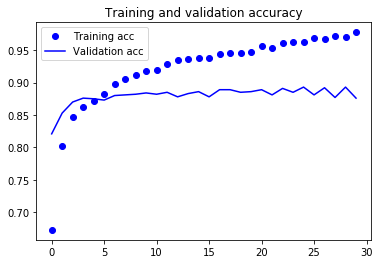

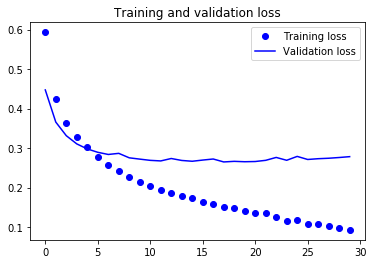

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

1. Add your custom network on top of an already trained base network.
1. Freeze the base network.
1. Train the part you added.
1. Unfreeze some layers in the base network.
1. Jointly train both these layers and the part you added.


We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

### Why not fine-tune more layers? 

Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

- Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:


In [25]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

In [26]:
history = model.fit_generator(
      train_gen,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_gen,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 102ms/step - loss: 0.3823 - acc: 0.8295 - val_loss: 0.3262 - val_acc: 0.8540
Epoch 2/30
100/100 [==============================] - 9s 93ms/step - loss: 0.3583 - acc: 0.8515 - val_loss: 0.2702 - val_acc: 0.8840
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 0.3651 - acc: 0.8380 - val_loss: 0.3058 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 9s 94ms/step - loss: 0.3854 - acc: 0.8165 - val_loss: 0.2796 - val_acc: 0.8690
Epoch 5/30
100/100 [==============================] - 9s 94ms/step - loss: 0.3482 - acc: 0.8505 - val_loss: 0.2934 - val_acc: 0.8740
Epoch 6/30
100/100 [==============================] - 9s 94ms/step - loss: 0.3500 - acc: 0.8410 - val_loss: 0.3002 - val_acc: 0.8650
Epoch 7/30
100/100 [==============================] - 9s 95ms/step - loss: 0.3704 - acc: 0.8330 - val_loss: 0.2962 - val_acc: 0.8830
Epoch 8/30
100/100 [==============================] - 9s 93ms/step 

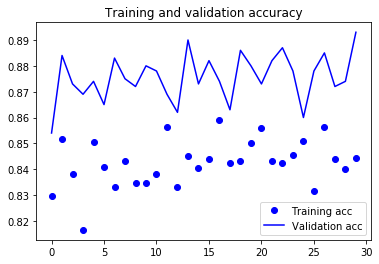

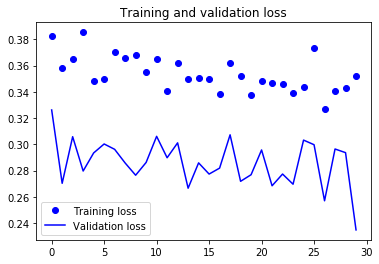

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

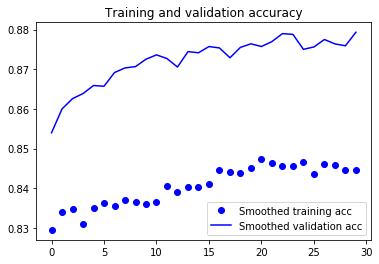

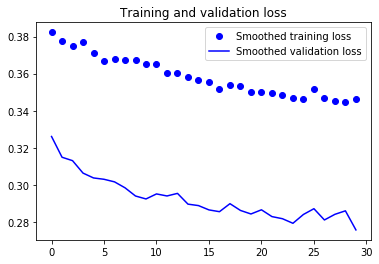

In [28]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:


In [29]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('test acc:', test_acc)

test acc: 0.8969999957084656


### Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

- Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
- It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
- As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.


### Approaches to get a better score

- More aggresive data augmentation
- More aggressive dropout
- Use of L1 and L2 regularization (also known as "weight decay")
- Fine-tuning one more convolutional block (alongside greater regularization)

### Prediction

In [30]:
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input, decode_predictions

# # assuming that model is your saved and trained model
# model1 = applications.VGG16(include_top=False, weights='imagenet')
# img = image.load_img('imagename.jpg', target_size=(img_width, img_height))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# features = model1.predict(x)

# # this is where you get your prediction
# prediction = model.predict(features)

Try this later on for practice:
    https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.7-predicting-house-prices.ipynb